# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [87]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


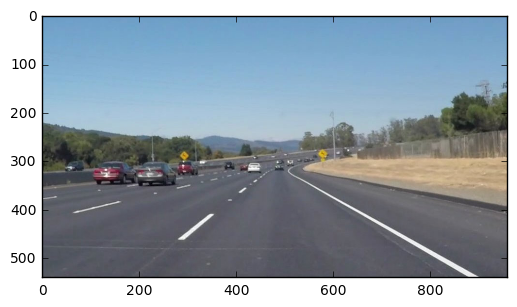

In [88]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [123]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    Atchi : This functions filters lines < 20deg slant
     #if abs( (y2-y1)/(x2-x1) ) > 0.57 :   # Filter lines  with inclination < 30deg
          
    """
    
    # *************************************************
    # Filter Out Horizontal/vertical Lines
    # *************************************************
    # Lines array is of  Nx1X4 dimensions, each observation 
    # has x1, x2, y1, y2 coordinates.
    #                   x-cord
    lines = lines[ (lines[:,:, 0] != lines[:,:, 2] ) ]



    # ************************************************
    # compute slope, y-intercept and append to lines
    # ************************************************
    ##     slope  =   (     y2      -    y1        ) /  (     x2      -    x1   )
    slope =    ( lines[:,3] - lines[:,1] ) / ( lines[:,2] - lines[:,0] )

    ##       b    =     y         -       m      *     x
    intercept =  lines[:,1] - (slope*lines[:,0])

    ## append to lines array
    intercept.shape = (intercept.shape[0],1)    # typecasting vector from above operation to array
    slope.shape = (slope.shape[0],1)            # typecasting vector from above operation to array
    lines = np.append(lines, slope, 1)
    lines = np.append(lines,intercept,1)



    # ***********************************************
    #    Filter Lines angle < 30deg
    # ***********************************************
    lines = lines[ abs(lines[:,4]) > 0.57]



    # **********************************************
    # Categorize left and Right lines
    # **********************************************
    left_lines  = lines[ lines[:,4] < 0]
    right_lines = lines[ lines[:,4] > 0]


    # left line slope & intercept
    left_line_slope     = np.mean(left_lines[:,4])
    left_line_intercept = np.mean(left_lines[:,5])
    
    # right line slope and intercept
    right_line_slope    =  np.mean(right_lines[:,4])
    right_line_intercept = np.mean(right_lines[:,5])
    

    
    # **********************************************
    # Draw Left & Right Lane Lines    
    # **********************************************
    # Image dimensions
    imht, imwid, imdep  =  img.shape

    # Limit lane line vertical span to 40% of Image Height,
    # compute x by plugging in slope,y and intercept
    y1 = math.floor(0.6 * imht)
    y2 = imht

    cv2.line(img,                            \
             ( math.floor( (y1 - left_line_intercept) / left_line_slope ) , y1 ),  \
             ( math.floor( (y2 - left_line_intercept) / left_line_slope ) , y2 ),  \
             color,     \
             thickness, \
             )

    cv2.line(img,                            \
             ( math.floor( (y1 - right_line_intercept) / right_line_slope ) , y1 ),  \
             ( math.floor( (y2 - right_line_intercept) / right_line_slope ) , y2 ),  \
             color,     \
             thickness, \
             )
    # ***** End of draw_lines *****
    
    
def draw_lines_h(img, lines, color=[255,0,0], thickness=2): 
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (x1==x2) or (y1==2) :             # Filter Horizontal/Veritcal lines
                continue
            if abs( (y2-y1)/(x2-x1) ) > 0.57 :   # Filter lines  with inclination < 30deg
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    return lines
 
 
    
    
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [90]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg']

In [118]:


def cannyAndMaskStudy(image):
    """
        Lane lines from the camera feed has varying intesity w.r.t  far/near sight distance.
        For a selected region, its a challenge to come-up with appropriate intensity thresholds
        for lane line detection.
        
        will study the canny edge detection performance for a set of threshold windows. Focus is
        on how which combination of  intensity and far/near sight distance maximize edge detection.
        
        incoming argument is color image 
    """
    
    gimage = grayscale(image)              # Convert to grayscale
    
    edges  = canny(gimage, 50, 150)       # Run Canny with 50:150 threshold
    
    
    # Apply Mask on Canny Transform output
    # will go with trapezoid mask, 10 and 90 % of image width forms base of trapezoid
    #  42 & 58 % forms the top of trapezoid    
    imwid   = image.shape[1]             # Columms
    imht    = image.shape[0]             # Rows
    
    ll = ( math.floor(imwid*0.1) , imht )       # Lower Left Vertex
    lr = ( math.floor(imwid*0.9) , imht )      # Lower Right Vertex
    tl = ( math.floor(imwid*0.42) , math.floor(imht*0.6) )      # Top Left Vertex
    tr = ( math.floor(imwid*0.58) , math.floor(imht*0.6) )      # Top Right Vertex
    vertices = np.array( [[ ll, tl, tr, lr]], dtype=np.int32)

    mask_image = region_of_interest(edges, vertices)  # Apply Mask
    
    lines = hough_lines(                       \
                        mask_image,            # Image \
                        1,                     # rho   \
                        np.pi/180,             # theta \
                        15,                    # Threshold \
                        4,                     # min line length \
                        2,                     # max_line_gap \
                        )
    
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    #print(lines.shape)
    draw_lines( image, lines)
    
    draw_lines_h(line_img, lines, [0,255,0])
    draw_lines(line_img, lines, [255,0,0])
    
    ##print(lines.shape)
    #glines = grayscale(lines)
    ## Add Grid Lines
        
    ## Add Grid and Concat Images for Study
    #_edges = np.append(mask_image, glines , 1)            # Concat edges and masked Edges
    
    #xgrid = np.array([0.5, 0.6, 0.7, 0.8, 0.9])
    #np.array(imht * xgrid)
    #_edges[ (imht * xgrid).astype('int') , : ] = 255      # Add Horizontal Grid Lines
    
    #ygrid = np.array([ 0.1, 0.2, 0.4, 0.42, 0.58, 0.6, 0.8, 0.9, 1.1, 1.2, 1.4, 1.42, 1.58, 1.6, 1.8, 1.9])
    #_edges[ :, (imwid * ygrid).astype('int') ] = 255        # Add Vertical Grid Lines    
    
    #edges  = np.append(gimage, _edges, 1)               # Concat gimage and edges
    
    edges = np.append(image, line_img, 1)
    
    return(edges)

In [124]:
# Run Canny Threshold Study on :-  solidWhiteRight  testcase

for img in os.listdir("solidWhiteRight/inputImage"):
    image = plt.imread("solidWhiteRight/inputImage/"+img)
    edges = cannyAndMaskStudy(image)
    plt.imsave("solidWhiteRight/canny+mask+hough+lanelines/"+img, edges, cmap='gray')

In [125]:
# Run Canny Threshold Study on :-  solidYellowLeft  testcase

for img in os.listdir("solidYellowLeft/inputImage"):
    image = plt.imread("solidYellowLeft/inputImage/"+img)
    edges = cannyAndMaskStudy(image)
    plt.imsave("solidYellowLeft/canny+mask+hough+lanelines/"+img, edges, cmap='gray')

In [126]:
# Run Canny Threshold Study on :-  Challenge  testcase

for img in os.listdir("challenge/inputImage"):
    image = plt.imread("challenge/inputImage/"+img)
    edges = cannyAndMaskStudy(image)
    plt.imsave("challenge/canny+mask+hough+lanelines/"+img, edges, cmap='gray')

(540, 960, 3)
(540, 960, 3)


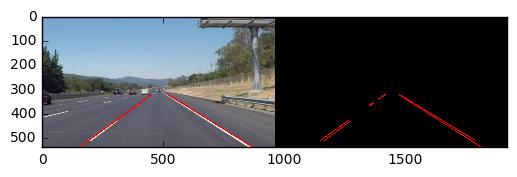

In [86]:


def houghl(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    return lines

color=[255, 0, 0] 
thickness=4

image = plt.imread("challenge/inputImage/challenge_1.jpg")
image = plt.imread("solidWhiteRight/inputImage/solidWhiteRight_1.jpg")

gimage = grayscale(image)




edges = canny(gimage, 50, 150)


# Apply Mask on Canny Transform output
# will go with trapezoid mask, 10 and 90 % of image width forms base of trapezoid
#  42 & 58 % forms the top of trapezoid    
imwid   = image.shape[1]             # Columms
imht    = image.shape[0]             # Rows
    
ll = ( math.floor(imwid*0.1) , imht )       # Lower Left Vertex
lr = ( math.floor(imwid*0.9) , imht )      # Lower Right Vertex
tl = ( math.floor(imwid*0.42) , math.floor(imht*0.6) )      # Top Left Vertex
tr = ( math.floor(imwid*0.58) , math.floor(imht*0.6) )      # Top Right Vertex
vertices = np.array( [[ ll, tl, tr, lr]], dtype=np.int32)

mask_image = region_of_interest(edges, vertices)  # Apply Mask
    


lines = houghl(mask_image, 1, np.pi/180, 15, 5, 2)
lines_h = hough_lines(mask_image, 1, np.pi/180, 15, 5, 2)


# *************************************************
# Filter Out Horizontal/vertical Lines
# *************************************************
# Lines array is of  Nx1X4 dimensions, each observation 
# has x1, x2, y1, y2 coordinates.
#                   x-cord
lines = lines[ (lines[:,:, 0] != lines[:,:, 2] ) ]



# ************************************************
# compute slope, y-intercept and append to lines
# ************************************************
##     slope  =   (     y2      -    y1        ) /  (     x2      -    x1   )
slope =    ( lines[:,3] - lines[:,1] ) / ( lines[:,2] - lines[:,0] )

##       b    =     y         -       m      *     x
intercept =  lines[:,1] - (slope*lines[:,0])

## append to lines array
intercept.shape = (intercept.shape[0],1)    # typecasting vector from above operation to array
slope.shape = (slope.shape[0],1)            # typecasting vector from above operation to array
lines = np.append(lines, slope, 1)
lines = np.append(lines,intercept,1)



# ***********************************************
#    Filter Lines angle < 30deg
# ***********************************************
lines = lines[ abs(lines[:,4]) > 0.57]



# **********************************************
# Categorize left and Right lines
# **********************************************
left_lines  = lines[ lines[:,4] < 0]
right_lines = lines[ lines[:,4] > 0]


# left line slope & intercept
left_line_slope     = np.mean(left_lines[:,4])
left_line_intercept = np.mean(left_lines[:,5])
    
# right line slope and intercept
right_line_slope    =  np.mean(right_lines[:,4])
right_line_intercept = np.mean(right_lines[:,5])
    

    
# **********************************************
# Draw Left & Right Lane Lines    
# **********************************************
# Image dimensions
imht, imwid, imdep  =  image.shape

# Limit lane line vertical span to 40% of Image Height,
# compute x by plugging in slope,y and intercept
y1 = math.floor(0.6 * imht)
y2 = imht

cv2.line(image,                            \
             ( math.floor( (y1 - left_line_intercept) / left_line_slope ) , y1 ),  \
             ( math.floor( (y2 - left_line_intercept) / left_line_slope ) , y2 ),  \
             color,     \
             thickness, \
             )

cv2.line(image,                            \
             ( math.floor( (y1 - right_line_intercept) / right_line_slope ) , y1 ),  \
             ( math.floor( (y2 - right_line_intercept) / right_line_slope ) , y2 ),  \
             color,     \
             thickness, \
             )
    
    
print(image.shape)
print(lines_h.shape)
plt.imshow(np.append(image, lines_h, 1))


In [38]:
v = np.ones((3,2))
m = np.ones((3,1))
print(v.shape)
print(m.shape)
np.append(v,m)

(3, 2)
(3, 1)


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])